# Library

## Python packages 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import rpy2
import os
import functools as fct
from collections import Counter
import pickle

/Users/tanya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## R packages

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(rlang)
library(ggplot2)
library(dplyr)
library(scales)
library(reshape2)
library(cowplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Set Paths 

In [4]:
path_to_data = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data'
path_to_vcfs = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data/vcfs'   # path to initial ClinVar dfs
path_to_gatk = '/Users/tanya/Documents/tools/gatk-4.5.0.0/gatk'
path_to_tables = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/tables'
path_to_plots = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/plots'
path_to_temp = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/temp'

## Load data 

In [5]:
vep = pd.read_csv('./tables/VEP.csv', sep=',')
print(vep.shape)
vep.tail(3)

/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_35060/2768848983.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv('./tables/VEP.csv', sep=',')


(2296245, 25)


,CHROM,POS,ID,REF,ALT,SYMBOL,IMPACT,Consequence,MAX_AF,MAX_AF_POPS,...,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,LOCALAFDB_AF_healthy,CLNVC,CLNDISDB,CLNSIG_MASK
2296242,Y,12915989,2429753,A,AT,DDX3Y,HIGH,frameshift_variant,.,.,...,.,.,.,.,.,.,.,Duplication,"Human_Phenotype_Ontology:HP:0011961,MedGen:C40...",LP
2296243,Y,12916632,2429754,TG,T,DDX3Y,HIGH,frameshift_variant&splice_region_variant,.,.,...,.,.,.,.,.,.,.,Deletion,"Human_Phenotype_Ontology:HP:0011961,MedGen:C40...",LP
2296244,Y,21548157,2689863,G,T,RBMY1A1,MODERATE,missense_variant,.,.,...,.,.,.,.,.,.,.,single_nucleotide_variant,MedGen:C3661900,VUS


In [6]:
# add initial and clnsig to new column for COI, for non-coi NA

initial_clnsig_df = pd.read_csv('./tables/initial_clnsig_df.csv', sep='\t')
initial_clnsig_df.columns = ['ID', 'INITIAL_CLNSIG']

vep = vep.merge(initial_clnsig_df, on =['ID'], how='left')
vep.shape

(2296245, 26)

In [7]:
# add info whether variant is  missense or pLOF

mc_mask = pd.read_csv('./data/VEP_wMC_MASK.csv', sep=',')   # worst MC according to VEP annotation
mc_mask.head()

,Consequence,Consequence_MASK
0,3_prime_utr_variant,Other
1,5_prime_utr_variant,Other
2,coding_sequence_variant,Other
3,coding_sequence_variant&3_prime_utr_variant,Other
4,coding_sequence_variant&5_prime_utr_variant,Other


In [8]:
vep = vep.merge(mc_mask, on=['Consequence'], how='left')
vep.shape

(2296245, 27)

In [9]:
vep.groupby(['CLNSIG_MASK', 'Consequence_MASK']).size().reset_index().to_csv('./test.csv')

In [12]:
#pd.read_csv('./temp/coi_clnsigconf_df.csv',sep='\t').head(2)

,varid,initial_clnsig,clnsig_list,merged_list,clnsig_set
0,9,COI,"['B/LB', 'P/LP', 'P/LP', 'P/LP', 'P/LP', 'P/LP...","['Benign', 'Pathogenic', 'Pathogenic', 'Pathog...",B/LB|VUS|P/LP
1,10,COI,"['B/LB', 'P/LP', 'P/LP', 'P/LP', 'P/LP', 'P/LP...","['Likely_benign', 'Pathogenic', 'Pathogenic', ...",B/LB|VUS|P/LP


In [14]:
# flt genes with at least one P

#with open("pathogenic_genes_list", "rb") as fp:   # Unpickling
#    pathogenic_genes_list = pickle.load(fp)

#vep_flt = vep[vep['SYMBOL'].isin(pathogenic_genes_list)]

#vep_flt.shape

#vep = vep_flt

# Type of variant (IMPACT)

### ALL 

In [10]:
impact_stat = vep[['CLNSIG_MASK', 'IMPACT']]
impact_stat = impact_stat.groupby(['CLNSIG_MASK', 'IMPACT']).size().to_frame(name='count').reset_index() \
                 .merge(impact_stat.groupby('CLNSIG_MASK')['IMPACT'].count().reset_index(name='total'), on='CLNSIG_MASK') \
                 .assign(prop=lambda x: x['count'] / x['total']).sort_values(by=['CLNSIG_MASK', 'IMPACT'])

# reorder 

impact_stat['CLNSIG_MASK'] = pd.Categorical(impact_stat['CLNSIG_MASK'], categories=['COI','B', 'B/LB','LB','VUS','LP',
                                                                            'P/LP','P','Affects', 'association',
                                                                            'confers_sensitivity', 'drug_response',
                                                                            'not_provided','protective','risk_factor',
                                                                            'Uncertain_risk_allele', 'other'], ordered=True)
impact_stat['IMPACT'] = pd.Categorical(impact_stat['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW','MODIFIER'], ordered=True)

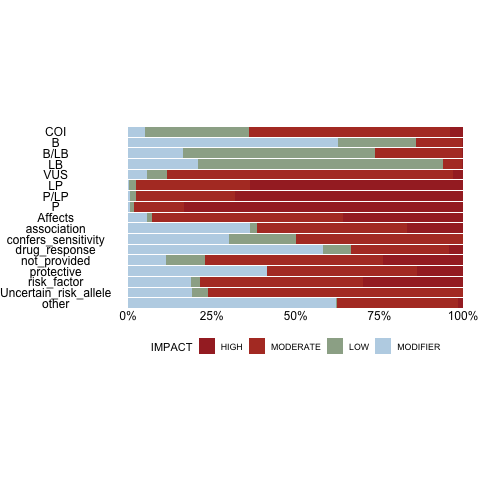

In [11]:
%%R  -i impact_stat

# plot 

impact_plt <- ggplot(impact_stat, aes(x=CLNSIG_MASK, y=prop, fill=IMPACT)) + 
  geom_bar(stat='identity') +theme_void() +
  theme(legend.position = "bottom", 
        axis.text=element_text(size=12),
        axis.title=element_text(size=12)) + ylab('') +
  xlab("")  + scale_x_discrete(limits=rev) + scale_y_continuous(labels = percent_format()) +
  scale_fill_manual(values = c( '#A62C2B','#B33C2C', '#9cae96', '#BCD4E6'))

impact_plt <- impact_plt + theme(aspect.ratio = 1/2)  + coord_flip()
impact_plt

impact_plt

#ggsave("./plots/impact_stat_ALL.png")

### COI (split by initial interpretation) 

In [12]:
impact_stat = vep[['INITIAL_CLNSIG', 'IMPACT']].dropna(subset=['INITIAL_CLNSIG'])

In [13]:
impact_stat = vep[['INITIAL_CLNSIG', 'IMPACT']].dropna(subset=['INITIAL_CLNSIG'])
impact_stat = impact_stat.groupby(['INITIAL_CLNSIG', 'IMPACT']).size().to_frame(name='count').reset_index() \
                 .merge(impact_stat.groupby('INITIAL_CLNSIG')['IMPACT'].count().reset_index(name='total'), on='INITIAL_CLNSIG') \
                 .assign(prop=lambda x: x['count'] / x['total']).sort_values(by=['INITIAL_CLNSIG', 'IMPACT'])

# reorder 

impact_stat['INITIAL_CLNSIG'] = pd.Categorical(impact_stat['INITIAL_CLNSIG'], categories=['COI','B', 'B/LB','LB','VUS','LP',
                                                                            'P/LP','P','Affects', 'association',
                                                                            'confers_sensitivity', 'drug_response',
                                                                            'not_provided','protective','risk_factor',
                                                                            'Uncertain_risk_allele', 'other'], ordered=True)
impact_stat['IMPACT'] = pd.Categorical(impact_stat['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW','MODIFIER'], ordered=True)

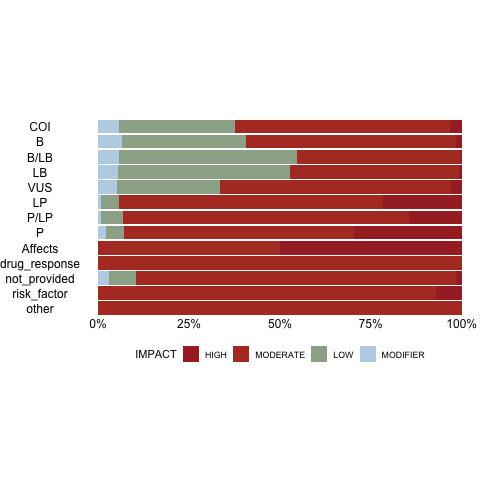

In [14]:
%%R  -i impact_stat

# plot 

impact_plt <- ggplot(impact_stat, aes(x=INITIAL_CLNSIG, y=prop, fill=IMPACT)) + 
  geom_bar(stat='identity') +theme_void() +
  theme(legend.position = "bottom", 
        axis.text=element_text(size=12),
        axis.title=element_text(size=12)) + ylab('') +
  xlab("")  + scale_x_discrete(limits=rev) + scale_y_continuous(labels = percent_format()) +
  scale_fill_manual(values = c( '#A62C2B','#B33C2C', '#9cae96', '#BCD4E6'))

impact_plt <- impact_plt + theme(aspect.ratio = 1/2)  + coord_flip()
impact_plt

impact_plt

#ggsave("./plots/impact_stat_COI.png")

# Molecular consequence

In [15]:
clnvc_stat = vep[['CLNSIG_MASK', 'CLNVC']]
clnvc_stat = clnvc_stat.groupby(['CLNSIG_MASK', 'CLNVC']).size().to_frame(name='count').reset_index() \
                 .merge(clnvc_stat.groupby('CLNSIG_MASK')['CLNVC'].count().reset_index(name='total'), on='CLNSIG_MASK') \
                 .assign(prop=lambda x: x['count'] / x['total']).sort_values(by=['CLNSIG_MASK', 'CLNVC'])

clnvc_stat['CLNSIG_MASK'] = pd.Categorical(clnvc_stat['CLNSIG_MASK'], categories=['COI','B', 'B/LB','LB','VUS','LP',
                                                                            'P/LP','P','Affects', 'association',
                                                                            'confers_sensitivity', 'drug_response',
                                                                            'not_provided','protective','risk_factor',
                                                                            'Uncertain_risk_allele', 'other'], ordered=True)


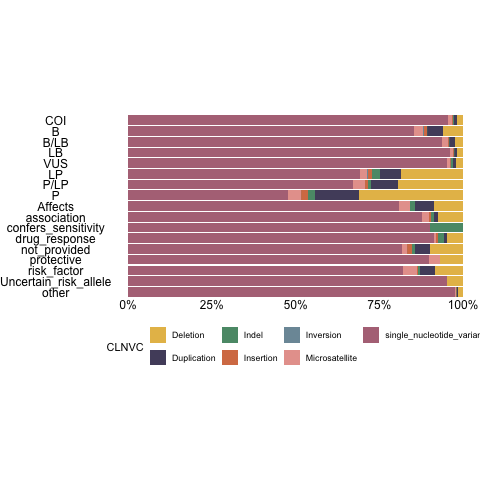

In [16]:
%%R -i clnvc_stat

# plot 
#clnvc_stat_wo_snp <- clnvc_stat[clnvc_stat$CLNVC!='single_nucleotide_variant', ]

clnvc_plt <- ggplot(clnvc_stat, aes(x=CLNSIG_MASK, y=prop, fill=CLNVC)) + 
  geom_bar(stat='identity') +theme_void() +
  theme(legend.position = "bottom", 
        axis.text=element_text(size=12),
        axis.title=element_text(size=12)) + ylab('') +
  xlab("")  + scale_x_discrete(limits=rev) + scale_y_continuous(labels = percent_format()) +
  scale_fill_manual(values = c( '#e6bd57','#534d6b', '#5b9877', '#d67d53',
                                '#7c98a6', '#e7a29c', '#b37486'))

clnvc_plt <- clnvc_plt + theme(aspect.ratio = 1/2)  + coord_flip()
clnvc_plt

#ggsave("./plots/clnvc_plt.png")

# Allele frequency (gnomAD/1KG)  - popmax, popmin,  global AF 

In [17]:
def get_min_excluding_dots(row): 
    """
    Function to handle dots and find minimum value
    """
  # Filter out non-numeric values (including dots)
    filtered_values = [val for val in row if str(val) != '.']
  # If there are numeric values, return minimum, otherwise a default value (e.g., 0)
    return min(filtered_values) if filtered_values else '.'  # Adjust default value as needed

# Add a new column with min value in each row
vep['MIN_AF'] = vep.iloc[:, 11:21].apply(get_min_excluding_dots, axis=1)

In [18]:
gnomad_af = vep[['CLNSIG_MASK', 'gnomADg_AF', 'MAX_AF', 'MIN_AF']]
gnomad_af['CLNSIG_MASK'] = pd.Categorical(gnomad_af['CLNSIG_MASK'], categories=['COI','B', 'B/LB','LB','VUS','LP',
                                                                            'P/LP','P','Affects', 'association',
                                                                            'confers_sensitivity', 'drug_response',
                                                                            'not_provided','protective','risk_factor',
                                                                            'Uncertain_risk_allele', 'other'], ordered=True)


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_35060/335666700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_af['CLNSIG_MASK'] = pd.Categorical(gnomad_af['CLNSIG_MASK'], categories=['COI','B', 'B/LB','LB','VUS','LP',


In [19]:
clnsig_list_cut = ['COI','B', 'B/LB','LB','VUS','LP','P/LP','P']

gnomad_af = gnomad_af[gnomad_af['CLNSIG_MASK'].isin(clnsig_list_cut)]

In [22]:
%%R -i gnomad_af

# plot popmax / popmin / AF global

gnomad_af$CLNSIG_MASK <- as.factor(gnomad_af$CLNSIG_MASK)
gnomad_af <- gnomad_af %>% mutate_if(is.character, as.numeric)

In addition: Warning message:
There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `gnomADg_AF = .Primitive("as.double")(gnomADg_AF)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings. 


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 4393 rows containing non-finite outside the scale range
(`stat_ydensity()`). 

R[write to console]: 2: Removed 4393 rows containing non-finite outside the scale range
(`stat_boxplot()`). 



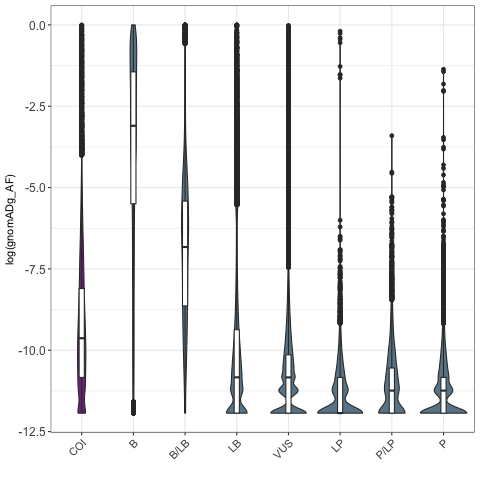

In [23]:
%%R 
# plot popmax
theme_set(theme_bw())
af_plt <- ggplot(na.omit(gnomad_af),
                 aes(x=CLNSIG_MASK,
                     #y=log(MAX_AF),
                     #y=log(MIN_AF),
                     #y=log(gnomADg_AF),
                     fill=CLNSIG_MASK
                    )) + geom_violin(adjust=1.5) + geom_boxplot(width=0.1, fill='white') + theme(legend.position = "none", axis.text=element_text(size=12),axis.text.x = element_text(size = 11, , angle = 45, hjust=1)) + xlab("") + xlab("") + scale_fill_manual(values=c('#7F388B', '#698596', '#698596', '#698596',
                                                  '#698596', '#698596', '#698596', '#698596'))

af_plt
#ggsave("MAXAF_plt.png")
#ggsave("MINAF_plt.png")
#ggsave("gnomADg_plt.png")

In [24]:
vep.to_csv(f'{path_to_tables}/VEP_jn5mod.csv', sep=',', index=False)